In [22]:
import pandas as pd
import numpy as np

# 加载
dataset = pd.read_csv('./SupplyChain.csv', encoding='unicode_escape')
dataset
# 查缺失值
dataset.isnull().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


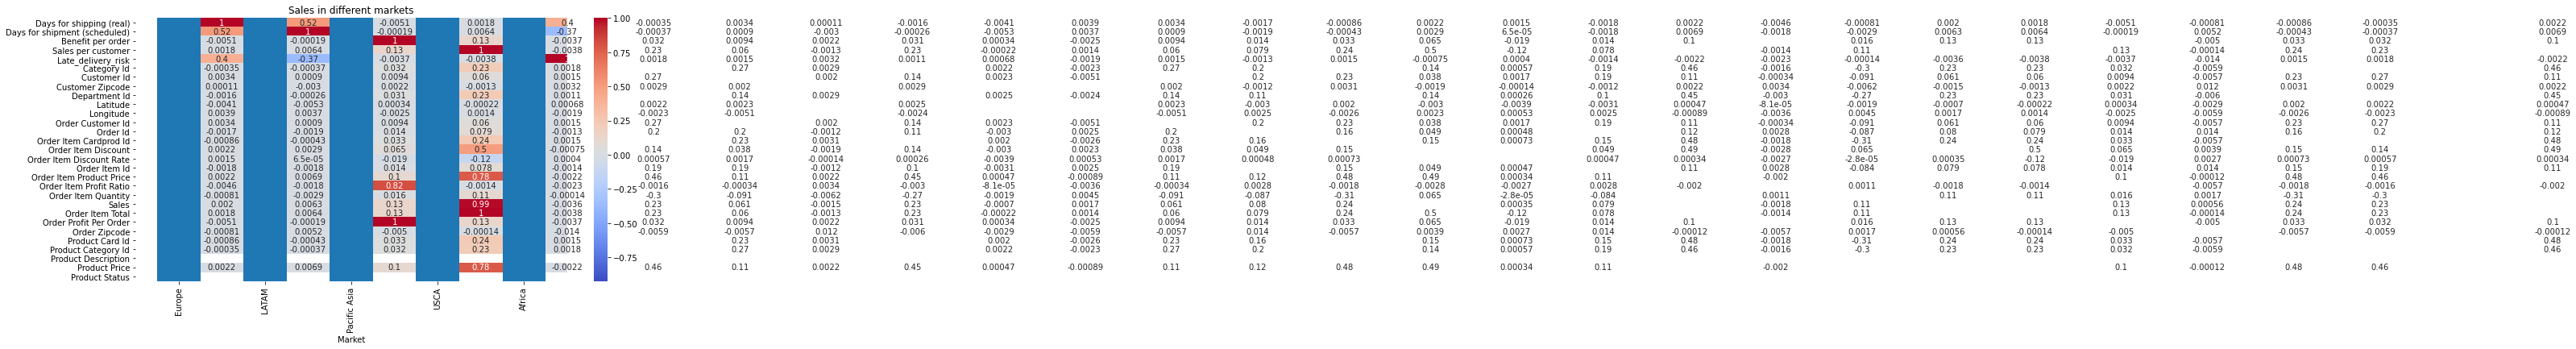

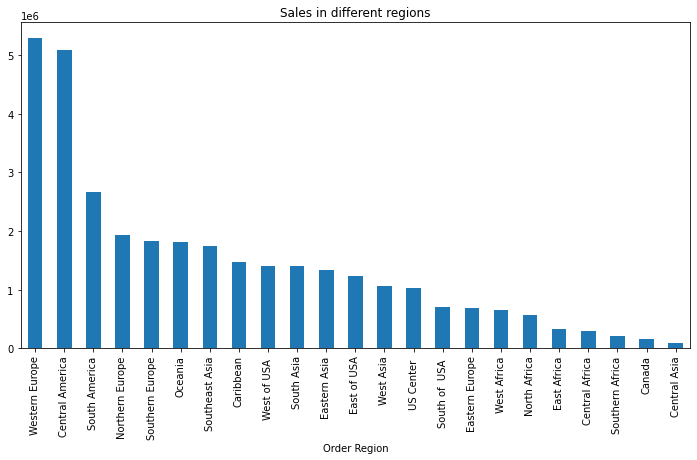

In [23]:
dataset[['Customer Fname', 'Customer Lname']]

dataset['Customer Full Name'] = dataset['Customer Fname'] +' '+ dataset['Customer Lname']

dataset['Customer Zipcode'].value_counts()

dataset['Customer Zipcode'] = dataset['Customer Zipcode'].fillna(0)
dataset['Customer Zipcode'].value_counts()

import matplotlib.pyplot as plt
import seaborn as sns

# 特征字段相关性
data = dataset
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),annot = True, cmap='coolwarm')

# 基于Market进行聚合
data['Market'].value_counts()
market = data.groupby('Market')
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title='Sales in different markets')
plt.show()
# 基于Order Region进行聚合
region = data.groupby('Order Region')
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title='Sales in different regions')
plt.show()

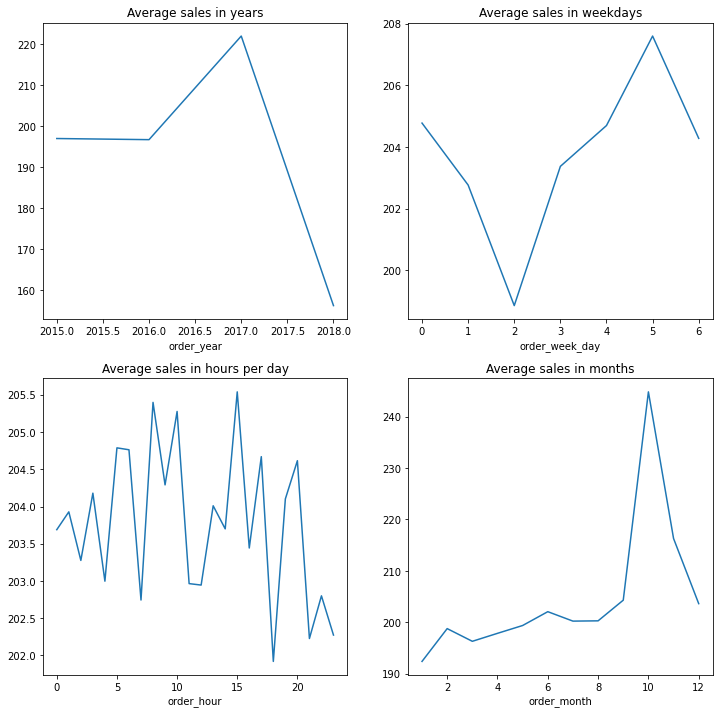

In [24]:
# 按照不同的时间维度（年、月、星期、小时）的趋势
data['order date (DateOrders)'].value_counts()
temp = pd.DatetimeIndex(data['order date (DateOrders)'])
temp
data['order_year'] = temp.year
data['order_month'] = temp.month
data['order_week_day'] = temp.weekday
data['order_hour'] = temp.hour
data['order_month_year'] = temp.to_period('M')
data[['order_year', 'order_month', 'order_week_day', 'order_hour', 'order_month_year']]

#  对销售额进行探索， 按照不同的时间维度
plt.figure(figsize=(20,10))
plt.subplot(221)
df_year = data.groupby('order_year')
df_year['Sales'].mean().plot(figsize=(12,12), title='Average sales in years')

plt.subplot(222)
df_day = data.groupby('order_week_day')
df_day['Sales'].mean().plot(figsize=(12,12), title='Average sales in weekdays')

plt.subplot(223)
df_hour = data.groupby('order_hour')
df_hour['Sales'].mean().plot(figsize=(12,12), title='Average sales in hours per day')

plt.subplot(224)
df_month = data.groupby('order_month')
df_month['Sales'].mean().plot(figsize=(12,12), title='Average sales in months')

In [25]:

data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Total']
data[['TotalPrice','Order Item Quantity', 'Order Item Total']]
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])
data['order date (DateOrders)']

0        2018-01-31 22:56:00
1        2018-01-13 12:27:00
2        2018-01-13 12:06:00
3        2018-01-13 11:45:00
4        2018-01-13 11:24:00
                 ...        
180514   2016-01-16 03:40:00
180515   2016-01-16 01:34:00
180516   2016-01-15 21:00:00
180517   2016-01-15 20:18:00
180518   2016-01-15 18:54:00
Name: order date (DateOrders), Length: 180519, dtype: datetime64[ns]

In [26]:

import datetime
present = datetime.datetime(2018, 2, 1)

customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)':lambda x:(present-x.max()).days, \
                                                     'Order Id': lambda x: len(x),'TotalPrice': lambda x: x.sum()})
customer_seg
customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 'Order Id': 'F_Value', 'TotalPrice': 'M_Value'},inplace = True)
customer_seg
# 将RFM划分4个尺度
quantiles = customer_seg.quantile([0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
quantiles

# R_value越小越好 =》 R_score
def R_Score(a, b, c):
    if a <= c[b][0.25]:
        return 4
    elif a<= c[b][0.50]:
        return 3
    elif a<= c[b][0.75]:
        return 2
    else:
        return 1

def FM_Score(a, b ,c):
    if a <= c[b][0.25]:
        return 1
    elif a<= c[b][0.50]:
        return 2
    elif a<= c[b][0.75]:
        return 3
    else:
        return 4
    
 # 新建R_score 字段用于将R_value=>[1,4]
customer_seg['R_Score'] = customer_seg['R_Value'].apply(R_Score, args=('R_Value', quantiles))
# 新建F_score、M_score 字段用于将FM_value=>[1,4]
customer_seg['F_Score'] = customer_seg['F_Value'].apply(FM_Score, args=('F_Value', quantiles))
# M_score 字段用于将M_value=>[1,4]
customer_seg['M_Score'] = customer_seg['M_Value'].apply(FM_Score, args=('M_Value', quantiles))
customer_seg

### 计算RFM用户分层
def RFM_User(df):
    if df['M_Score'] > 2 and df['F_Score'] > 2 and df['R_Score'] > 2:
        return '重要价值用户'
    elif df['M_Score'] > 2 and df['F_Score'] <= 2 and df['R_Score'] > 2:
        return '重要发展用户'
    elif df['M_Score'] > 2 and df['F_Score'] > 2 and df['R_Score'] <= 2:
        return '重要保持用户'
    elif df['M_Score'] > 2 and df['F_Score'] <= 2 and df['R_Score'] <= 2:
        return '重要挽留客户'
    elif df['M_Score'] <= 2 and df['F_Score'] > 2 and df['R_Score'] > 2:
        return '一般价值用户'
    elif df['M_Score'] <= 2 and df['F_Score'] <= 2 and df['R_Score'] > 2:
        return '一般发展用户'
    elif df['M_Score'] <= 2 and df['F_Score'] > 2 and df['R_Score'] <= 2:
        return '一般保持用户'
    elif df['M_Score'] <= 2 and df['F_Score'] <= 2 and df['R_Score'] <= 2:
        return '一般挽留客户'

customer_seg['Customer_Segmenation'] = customer_seg.apply(RFM_User, axis=1)
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,Customer_Segmenation
Order Customer Id,,,,,,,
1,792,1,2362.250061,1,1,2,一般挽留客户
2,136,10,2842.700073,3,3,3,重要价值用户
3,229,18,6143.760057,2,4,4,重要保持用户
4,380,14,4370.629991,1,3,3,重要保持用户
5,457,7,2993.790032,1,2,3,重要挽留客户
...,...,...,...,...,...,...,...
20753,0,1,161.869995,4,1,1,一般发展用户
20754,0,1,172.660004,4,1,1,一般发展用户
20755,0,1,314.640015,4,1,2,一般发展用户


In [29]:
train_data  = data
train_data['Order Status']
import pickle
with open('datatemp.pkl', 'wb') as file:
    pickle.dump(data, file)


In [30]:
with open('datatemp.pkl', 'rb') as file:
    train_data = pickle.load(file)
train_data

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Product Status,shipping date (DateOrders),Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,order_month_year,TotalPrice
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,0,2/3/2018 22:56,Standard Class,Cally Holloway,2018,1,2,22,2018-01,314.640015
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,0,1/18/2018 12:27,Standard Class,Irene Luna,2018,1,5,12,2018-01,311.359985
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,0,1/17/2018 12:06,Standard Class,Gillian Maldonado,2018,1,5,12,2018-01,309.720001
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,0,1/16/2018 11:45,Standard Class,Tana Tate,2018,1,5,11,2018-01,304.809998
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,0,1/15/2018 11:24,Standard Class,Orli Hendricks,2018,1,5,11,2018-01,298.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,0,1/20/2016 3:40,Standard Class,Maria Peterson,2016,1,5,3,2016-01,399.980011
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,0,1/19/2016 1:34,Second Class,Ronald Clark,2016,1,5,1,2016-01,395.980011
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,0,1/20/2016 21:00,Standard Class,John Smith,2016,1,4,21,2016-01,391.980011
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,0,1/18/2016 20:18,Standard Class,Mary Smith,2016,1,4,20,2016-01,387.980011


In [31]:

import numpy as np
train_data['fraud'] = np.where(train_data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_data['Delivery Status'].value_counts()
train_data['late_delivery'] = np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)
train_data.drop(['Customer Email','Product Image','Customer Password','Customer Fname','Customer Lname','Order Status','Delivery Status'],axis=1,inplace=True )


train_data.drop(['Order Zipcode', 'Product Description','Customer Full Name'],axis = 1, inplace=True)
train_data.drop(['Latitude','Longitude','Customer Street','Product Status','Product Status','Order Item Id','Product Card Id','Order Customer Id'],axis = 1, inplace=True)
train_data.drop(['shipping date (DateOrders)','order date (DateOrders)','order_month_year'],axis = 1, inplace=True)
train_data

categorical_cols = train_data.select_dtypes(include='object').columns
categorical_cols
numerical_cols = train_data.select_dtypes(exclude='object').columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in categorical_cols:
        train_data[column]
        train_data[column] = le.fit_transform(train_data[column])



from sklearn.model_selection import train_test_split
# 构造model，对是否fraud进行预测
x_fraud = train_data.loc[:, train_data.columns != 'fraud']
y_fraud = train_data['fraud']
# 切分数据集
x_fraud_train, x_fraud_test, y_fraud_train, y_fraud_test = train_test_split(x_fraud, y_fraud, test_size=0.2)

# 构造model，对是否late_delivery进行预测
x_late = train_data.loc[:, train_data.columns != 'late_delivery']
y_late = train_data['late_delivery']
# 切分数据集
x_late_train, x_late_test, y_late_train, y_late_test = train_test_split(x_late, y_late, test_size=0.2)

# 数据规范化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_fraud_train = sc.fit_transform(x_fraud_train)
x_fraud_test = sc.transform(x_fraud_test)
x_late_train = sc.fit_transform(x_late_train)
x_late_test = sc.transform(x_late_test)


from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
# 需要对fraud， late_delivery完成评估
def model_stats(model, x_train, x_test, y_train, y_test, name='Fraud'):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    confusion = confusion_matrix(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    
    print('Model used:', model)
    print('{} Accuracy: {}%'.format(name, accuracy*100))
    print('{} Recall: {}%'.format(name, recall*100))
    print('{} Confusion Matrix:\n {}'.format(name, confusion))
    print('{} F1 Score: {}%'.format(name, f1*100))
    return accuracy, recall, f1



from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC


# 高斯朴素贝叶斯模型
GaussianNB_fraud = GaussianNB()
GaussianNB_late = GaussianNB()
# 模型训练和评估
acc_fraud, recall_fraud, f1_fraud = model_stats(GaussianNB_fraud, x_fraud_train, x_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
acc_late, recall_late, f1_late = model_stats(GaussianNB_late, x_late_train, x_late_test, y_late_train, y_late_test, 'Late Delivery')

from sklearn.metrics import mean_absolute_error, mean_squared_error
# 需要对Sales,Quantity 完成回归预测
def regression_model_stats(model, x_train, x_test, y_train, y_test, name='Sales'):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse= mean_squared_error(y_test,y_pred, squared=False)
    
    print('Model used:', model)
    print('{} MAE: {}%'.format(name, mae))
    print('{} MSE: {}%'.format(name, mse))
    print('{} RMSE: {}'.format(name, rmse))

    return mae, mse, rmse


x_sales = train_data.loc[:, train_data.columns != 'Sales per customer']
y_sales = train_data['Sales per customer']
# 数据集切分
x_sales_train, x_sales_test, y_sales_train, y_sales_test = train_test_split(x_sales, y_sales, test_size=0.2)

x_quantity = train_data.loc[:, train_data.columns != 'Order Item Quantity']
y_quantity = train_data['Order Item Quantity']
# 数据集切分
x_quantity_train, x_quantity_test, y_quantity_train, y_quantity_test = train_test_split(x_quantity, y_quantity, test_size=0.2)

# 数据规范化
sc = StandardScaler()
x_sales_train = sc.fit_transform(x_sales_train)
x_sales_test = sc.transform(x_sales_test)
x_quantity_train = sc.fit_transform(x_quantity_train)
x_quantity_test = sc.transform(x_quantity_test)

from sklearn.linear_model import Lasso
# 构建Lasso模型
lasso_Sales = Lasso()
lasso_Quantity = Lasso()
# 模型训练与评估
mae, mse, rmse = regression_model_stats(lasso_Sales, x_sales_train, x_sales_test, y_sales_train, y_sales_test, 'Sales')
mae, mse, rmse = regression_model_stats(lasso_Sales, x_quantity_train, x_quantity_test, y_quantity_train, y_quantity_test, 'Quantity')

Model used: GaussianNB()
Fraud Accuracy: 88.12596942167073%
Fraud Recall: 100.0%
Fraud Confusion Matrix:
 [[30983  4287]
 [    0   834]]
Fraud F1 Score: 28.01007556675063%
Model used: GaussianNB()
Late Delivery Accuracy: 100.0%
Late Delivery Recall: 100.0%
Late Delivery Confusion Matrix:
 [[16223     0]
 [    0 19881]]
Late Delivery F1 Score: 100.0%
Model used: Lasso()
Sales MAE: 0.7257589307293774%
Sales MSE: 0.9580132449162968%
Sales RMSE: 0.9787815103056947
Model used: Lasso()
Quantity MAE: 1.1391669031225102%
Quantity MSE: 1.7074991408236222%
Quantity RMSE: 1.3067131057824521
